## Deconstruct a basic pipeline

In [153]:
import torch
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [154]:
from diffusers import DDPMScheduler, UNet2DModel

scheduler = DDPMScheduler.from_pretrained('google/ddpm-celebahq-256')
model = UNet2DModel.from_pretrained('google/ddpm-celebahq-256', use_safetensor=True).to(device)

An error occurred while trying to fetch google/ddpm-celebahq-256: google/ddpm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


the schedular determines the steps and strategies for denoising. The pipeline integrates multiple components

In [155]:
scheduler.set_timesteps(175)
scheduler.timesteps

tensor([870, 865, 860, 855, 850, 845, 840, 835, 830, 825, 820, 815, 810, 805,
        800, 795, 790, 785, 780, 775, 770, 765, 760, 755, 750, 745, 740, 735,
        730, 725, 720, 715, 710, 705, 700, 695, 690, 685, 680, 675, 670, 665,
        660, 655, 650, 645, 640, 635, 630, 625, 620, 615, 610, 605, 600, 595,
        590, 585, 580, 575, 570, 565, 560, 555, 550, 545, 540, 535, 530, 525,
        520, 515, 510, 505, 500, 495, 490, 485, 480, 475, 470, 465, 460, 455,
        450, 445, 440, 435, 430, 425, 420, 415, 410, 405, 400, 395, 390, 385,
        380, 375, 370, 365, 360, 355, 350, 345, 340, 335, 330, 325, 320, 315,
        310, 305, 300, 295, 290, 285, 280, 275, 270, 265, 260, 255, 250, 245,
        240, 235, 230, 225, 220, 215, 210, 205, 200, 195, 190, 185, 180, 175,
        170, 165, 160, 155, 150, 145, 140, 135, 130, 125, 120, 115, 110, 105,
        100,  95,  90,  85,  80,  75,  70,  65,  60,  55,  50,  45,  40,  35,
         30,  25,  20,  15,  10,   5,   0])

In [156]:
sample_size = model.config.sample_size
print(sample_size)
noise = torch.randn((1, 3, sample_size, sample_size), device=device)

256


In [157]:
input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

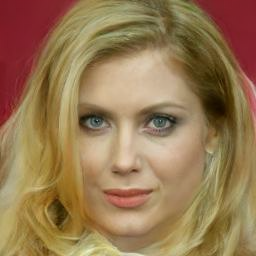

In [158]:
from PIL import Image
import numpy as np

image = (input / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image

## Deconstruct a stable diffusion pipeline

In [185]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="text_encoder", use_safetensors=True
)
unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True
)

In [186]:
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [187]:
device

device(type='cuda')

In [188]:
vae.to(device)
text_encoder.to(device)
unet.to(device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [189]:
prompt = ["a painting of a sunset over the ocean"]
height = 512  # default height of Stable Diffusion
width = 512# default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.Generator(device=device)  # Seed generator to create the initial latent noise
batch_size = len(prompt)

Tokenize the text and generate the embeddings from the prompt:

In [190]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

This code calculates the maximum length of the input sequence, tokenizes an empty string to create input suitable for the model, and generates embeddings for the tokenized input using a text encoder model.

The unconditional embeddings represent "no specific text condition."

Without it, the model strictly follows the prompt and generates text based on the prompt only, which is not natural, this makes the model more flexible.

In [191]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

In [192]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

## Denoise

In [193]:
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    device=device,
)

In [194]:
latents = latents * scheduler.init_noise_sigma

In [195]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

100%|██████████| 25/25 [00:59<00:00,  2.37s/it]


## Decode

In [196]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

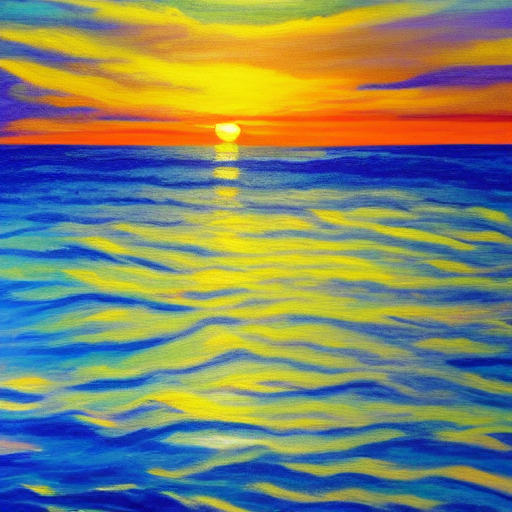

In [197]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image.save("output3.png")
image